Source: Practical Statistics for Data Scientists (Python)

Regression and Prediction

In [34]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [35]:
%matplotlib inline

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

# Multiple linear regression

### Topic: King County Housing Data. 
#### The goal is to predict the sales price from the other variables.


In [10]:
house = pd.read_csv('/Users/amrapaliMac/Library/CloudStorage/OneDrive-Personal/Practical statistics for data scientists practice/house_sales.csv',
                    sep='\t')
print(house.head())

  DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
1   2014-09-16     280000     1000102      Multiplex  2014-09-01   405100   
2   2006-06-16    1000000     1200013  Single Family  2006-06-01   404400   
3   2007-01-29     745000     1200019  Single Family  2007-01-01   425600   
4   2008-02-25     425000     2800016  Single Family  2008-02-01   418400   
5   2013-03-29     240000     2800024  Single Family  2013-03-01   351600   

   zhvi_idx  AdjSalePrice  NbrLivingUnits  SqFtLot  ...  Bathrooms  Bedrooms  \
1  0.930836      300805.0               2     9373  ...       3.00         6   
2  0.929228     1076162.0               1    20156  ...       3.75         4   
3  0.977941      761805.0               1    26036  ...       1.75         4   
4  0.961397      442065.0               1     8618  ...       3.75         5   
5  0.807904      297065.0               1     8620  ...       1.75         4   

   BldgGrade  YrBuilt  YrRenovated  TrafficNoise  LandVa

In [11]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']


house = pd.read_csv('/Users/amrapaliMac/Library/CloudStorage/OneDrive-Personal/Practical statistics for data scientists practice/house_sales.csv',
                    sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [12]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

# The zip() function is used to iterate over the names of the predictors and the corresponding coefficients obtained from the LinearRegression object.
print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -521871.368
Coefficients:
 SqFtTotLiving: 228.83060360240785
 SqFtLot: -0.060466820653068964
 Bathrooms: -19442.840398321077
 Bedrooms: -47769.95518521434
 BldgGrade: 106106.96307898086


# Assessing the Model

In [13]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

# The pandas method assign, as used here, adds a constant column with value 1 to the predictors. This is required to model the intercept.
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
results.summary()

RMSE: 261220
r2: 0.5406


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:16:44   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694      0.000     221.189     236.472
SqFtLot          -0.0605      0.061     -0.988      0.323      -0.180       0.059
Bathrooms     -1.944e+04   3625.388     -5.363      0.000   -2.65e+04   -1.23e+04
Bedrooms      -4.777e+04   2489.732    -19.187      0.000   -5.27e+04   -4.29e+04
BldgGrade      1.061e+05   2396.445     44.277      0.000    1.01e+05    1.11e+05
const         -5.219e+05   1.57e+04    -33.342      0.000   -5.53e+05   -4.91e+05
==============================================================================
Omnibus:                    29676.557   Durbin-Watson:                   1.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         19390738.346
Skew:                           6.889   Prob(JB):                         0.00
Kurtosis:                     145.559   Cond. No.                     2.86e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model Selection and Stepwise Regression

Before fitting the model, X is created as a design matrix by encoding categorical variables as dummy variables using pd.get_dummies(). drop_first=True is used to avoid the dummy variable trap.

In [14]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
X

,SqFtTotLiving,SqFtLot,Bathrooms,Bedrooms,BldgGrade,NbrLivingUnits,SqFtFinBasement,YrBuilt,YrRenovated,NewConstruction,PropertyType_Single Family,PropertyType_Townhouse
1,2400,9373,3.00,6,7,2,0,1991,0,0,0,0
2,3764,20156,3.75,4,10,1,1452,2005,0,1,1,0
3,2060,26036,1.75,4,8,1,900,1947,0,0,1,0
4,3200,8618,3.75,5,7,1,1640,1966,0,0,1,0
5,1720,8620,1.75,4,7,1,0,1948,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
27057,1480,5468,1.75,3,7,1,590,1951,0,0,1,0
27058,4720,23914,4.50,4,11,1,910,2000,0,0,1,0
27061,1070,11170,1.00,4,6,1,0,1971,0,0,1,0
27062,1345,6223,2.00,3,7,1,0,1939,0,0,1,0


After creating the design matrix, sm.OLS() is used to fit the model, with the dependent variable specified as house[outcome] and the independent variables specified as X.assign(const=1). const=1 is added to include a constant term in the model. The fit() method is then used to estimate the parameters of the model and print a summary of the results using print(results.summary()).

In [15]:
house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Thu, 20 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:16:44   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

The algorithm starts with an empty set of variables and iteratively adds or removes variables to maximize the AIC score of the resulting model. The final output is the best model and the set of variables that produced the best AIC score.
This applies the stepwise selection algorithm on the features in X using the train_model and score_model functions defined earlier. It returns the best model (best_model) and the selected variables (best_variables) for the best-performing model.

In [16]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:  
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    # this calculates the AIC score for the model, given the selected variables and the target variable.
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None



In [17]:
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201875
 BldgGrade: 137159.5602261977
 YrBuilt: -3565.4249392492966
 Bedrooms: -51947.383673613156
 Bathrooms: 42396.16452771775
 PropertyType_Townhouse: 84479.1620330041
 SqFtFinBasement: 7.046974967553979
 PropertyType_Single Family: 22912.05518701767


## Weighted regression

For example, with the housing data, older sales are less reliable than more recent sales. Using the DocumentDate to determine the year of the sale, we can compute a Weight as the number of years since 2005 (the beginning of the data):

The first line creates a new column called 'Year' by splitting the 'DocumentDate' column on the '-' character and taking the first part, which represents the year, as an integer. The new 'Year' column is created as a list comprehension, where each element in the 'DocumentDate' column is split, and the first part is converted to an integer using the int() function.

The second line does the same thing, but uses the apply() method instead of a list comprehension. The apply() method applies the lambda function lambda d: int(d.split('-')[0]) to each element in the 'DocumentDate' column, where d is the value of each element, and the result is assigned to the new 'Year' column.

The third line creates a new column called 'Weight' by subtracting 2005 from the 'Year' column, which represents the number of years since 2005. This creates a continuous variable that could be used as a predictor in a regression model.

In [18]:
house.DocumentDate

1        2014-09-16
2        2006-06-16
3        2007-01-29
4        2008-02-25
5        2013-03-29
            ...    
27057    2011-04-08
27058    2007-09-28
27061    2012-07-09
27062    2006-05-26
27063    2007-01-09
Name: DocumentDate, Length: 22687, dtype: object

In [19]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005
print(house['Weight'])
print(house['Year'])

1        9
2        1
3        2
4        3
5        8
        ..
27057    6
27058    2
27061    7
27062    1
27063    2
Name: Weight, Length: 22687, dtype: int64
1        2014
2        2006
3        2007
4        2008
5        2013
         ... 
27057    2011
27058    2007
27061    2012
27062    2006
27063    2007
Name: Year, Length: 22687, dtype: int64


The code below is fitting two linear regression models to the 'house' dataset. The first model, 'house_lm', is a simple linear regression model that does not take into account any sample weights.The second model, 'house_wt', takes into account sample weights. It is fitted using the same predictors and outcome variable as 'house_lm', but the sample_weight parameter is set to 'house.Weight', which is a new column that was created in the 'house' dataframe by subtracting 2005 from the 'Year' column. The code then concatenates the coefficients and intercepts of both models into a single dataframe, which is displayed. The purpose of this is to compare the coefficients and intercepts of the two models to see if there are any significant differences due to the use of sample weights in 'house_wt'. 

In [20]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
print(house_wt)


LinearRegression()


In [21]:
pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,    
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,    
    })
])

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


In [22]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())


   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013


(0.0, 300000.0)

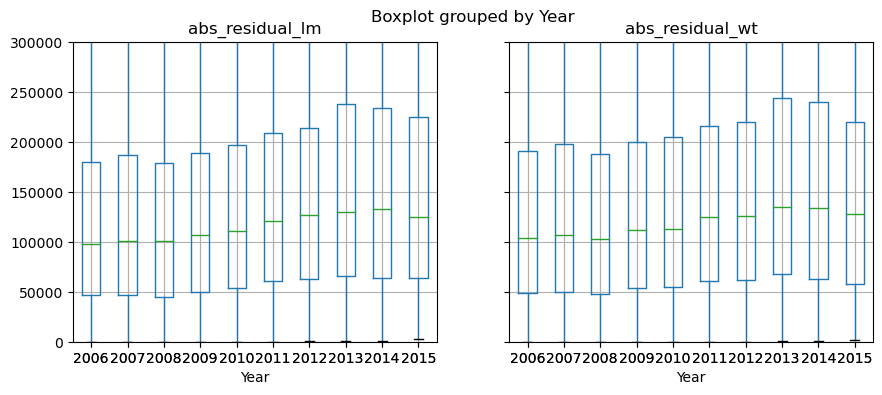

In [23]:
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)




In [24]:
# create a new DataFrame that shows the mean absolute residuals for each year, separately for the two models. 
pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])

,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


In [25]:
for year, group in residuals.groupby('Year'):
    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

2006 140540.30358478543 146557.45463555594
2007 147747.5779586304 152848.5232346336
2008 142086.9059427 146360.4116683415
2009 147016.7208834004 151182.92482502622
2010 163267.6748845873 166364.4761521068
2011 169937.38574413778 172950.87602774086
2012 169506.67005335895 171874.4242657243
2013 203659.77750995316 206242.19940256965
2014 184452.84066460092 186668.57375049713
2015 172323.43514674628 169842.74205317328


# Factor variables in regression
## Dummy Variables Representation

In [26]:
print(house.PropertyType.head())


1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


In [27]:
print(pd.get_dummies(house['PropertyType']).head(6))

   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1


In [37]:
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [38]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')
    

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503816
 SqFtLot: -0.07036798136811129
 Bathrooms: -15979.013473415169
 Bedrooms: -50889.73218483021
 BldgGrade: 109416.30516146177
 PropertyType_Single Family: -84678.21629549259
 PropertyType_Townhouse: -115121.9792160919


In [ ]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
# axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
# axes[0].set_ylim(0, 300000)

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])
# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

# Factor variables in regression
## Dummy Variables Representation

In [41]:
print(house.PropertyType.head())

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


In [42]:

print(pd.get_dummies(house['PropertyType']).head(6))

   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1


In [43]:

print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [44]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.37362892503816
 SqFtLot: -0.07036798136811129
 Bathrooms: -15979.013473415169
 Bedrooms: -50889.73218483021
 BldgGrade: 109416.30516146177
 PropertyType_Single Family: -84678.21629549259
 PropertyType_Townhouse: -115121.9792160919


## Factor Variables with many levels

In [45]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())

         98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
ZipCode    788    671    641    620    619    614    575    517    513    502   

         ...  98051  98024  98354  98050  98057  98288  98224  98068  98113  \
ZipCode  ...     32     31      9      7      4      4      3      1      1   

         98043  
ZipCode      1  

[1 rows x 80 columns]


In [55]:
house = pd.read_csv('/Users/amrapaliMac/Library/CloudStorage/OneDrive-Personal/Practical statistics for data scientists practice/house_sales.csv',
                    sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())




0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


In [69]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

# Interpreting the Regression Equation
## correlated predictor

In [70]:
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201875
 BldgGrade: 137159.5602261977
 YrBuilt: -3565.4249392492966
 Bedrooms: -51947.383673613156
 Bathrooms: 42396.16452771775
 PropertyType_Townhouse: 84479.1620330041
 SqFtFinBasement: 7.046974967553979
 PropertyType_Single Family: 22912.05518701767


Bedroom is negative. This implies that adding a bedroom to a house will reduce its value. How can this be? This is because the predictor variables are correlated: larger houses tend to have more bedrooms, and it is the size that drives house value, not the number of bedrooms. Consider two homes of the exact same size: it is reasonable to expect that a home with more but smaller bedrooms would be considered less desirable.

Removing the variables SqFtTotLiving, SqFtFinBasement, and Bathrooms,in Python, there is no equivalent to R’s update function. We need to refit the model with the modified predictor list:

In [71]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])


print(f'Intercept: {reduced_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f' {name}: {coef}')

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.537230215414
 BldgGrade: 248997.79366213744
 YrBuilt: -3211.744862155145
 PropertyType_Single Family: -19898.495340502413
 PropertyType_Townhouse: -47355.43687334484


## Confounding variables

 The regression coefficients of SqFtLot, Bathrooms, and Bedrooms are all negative. The original regression model does not contain a variable to represent location

In [73]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.6126600558016
 SqFtLot: 0.45498713854658845
 Bathrooms: 5928.425640001528
 Bedrooms: -41682.87184074468
 BldgGrade: 98541.1835272597
 PropertyType_Single Family: 19323.625287919225
 PropertyType_Townhouse: -78198.72092762412
 ZipGroup_1: 53317.17330659816
 ZipGroup_2: 116251.58883563543
 ZipGroup_3: 178360.5317879337
 ZipGroup_4: 338408.60185652017


The coefficients of SqFtLot and Bathrooms are now positive, and adding a bathroom increases the sale price by $5,928.

## Interactions and Main Effects

In Python, we need to use the statsmodels package to train linear regression models with interactions. 
The statsmodels package takes care of categorical variables (e.g., ZipGroup[T.1], PropertyType[T.Single Family]) and interaction terms (e.g., SqFtTotLiv ing:ZipGroup[T.1]).

In [76]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + ' +
     'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Sat, 22 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:32:05   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

# Testing the Assumptions: Regression Diagnostics
## Outliers

In [77]:
# The above code is fitting an Ordinary Least Squares (OLS) model on a subset of the house dataframe where the ZipCode is equal to 98105.
house_98105 = house.loc[house['ZipCode'] == 98105, ]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Sat, 22 Apr 2023   Prob (F-statistic):          1.69e-103
Time:                        12:09:34   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

The first line creates an instance of the OLSInfluence class from the statsmodels library, which is used to compute influence and outlier measures for a linear regression model. The result_98105 object is passed as an argument to the constructor of OLSInfluence, which sets up the necessary data structures to compute the influence measures.

The second line computes the minimum studentized residual and its index from the sresiduals array, which contains the internally studentized residuals for the model. The idxmin() method returns the index of the smallest value in the sresiduals array, and the min() method returns the corresponding value.

In other words, the second line is finding the observation in the data set with the smallest internally studentized residual, which is a measure of how unusual or extreme the residual is relative to the rest of the data set after adjusting for leverage and other factors. This observation is a potential outlier that may be worth investigating further.

In [78]:
# In statsmodels, use OLSInfluence to analyze the residuals:
# The OLSInfluence class is initialized with the OLS regression results and gives access to a number of usefule properties. Here we use the studentized residuals.
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal
sresiduals.idxmin(), sresiduals.min()

(24333, -4.326731804078564)

The biggest overestimate from the model is more than four standard errors above the regression line, corresponding to an overestimate of $757,754. 
The resid attribute of a OLSResults object contains the residuals of the regression. To print the residual corresponding to the observation with the smallest studentized residual, you can use the following code:

In [79]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115829


In [80]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePrice', outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


In this case, it appears that there is something wrong with the record: a house of that size typically sells for much more than $119,748 in that zip code. Figure 4-4 shows an excerpt from the statutory deed from this sale: it is clear that the sale involved only partial interest in the property. In this case, the outlier corresponds to a sale that is anomalous and should not be included in the regression. 

## Influential values

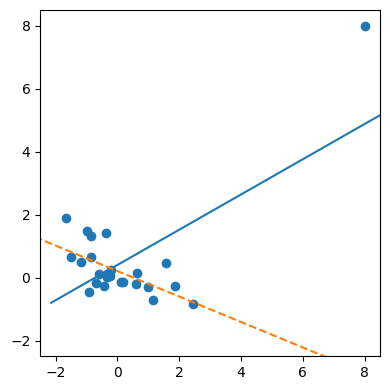

In [81]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

The package statsmodel provides a number of plots to analyze the data point influence

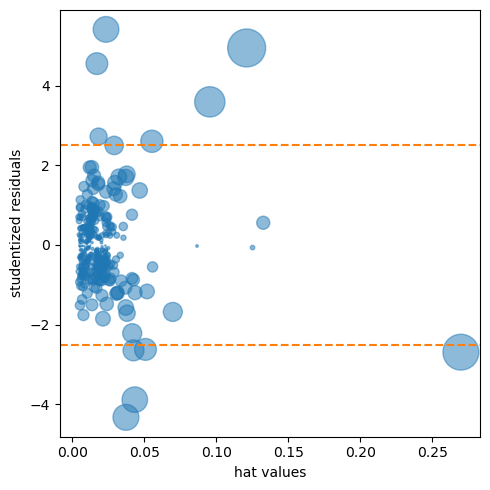

In [82]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal, 
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [83]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Original': result_98105.params,
    'Influential removed': result_infl.params,
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


# Heteroskedasticity, Non-Normality and Correlated Errors

The regplot in seaborn allows adding a lowess smoothing line to the scatterplot

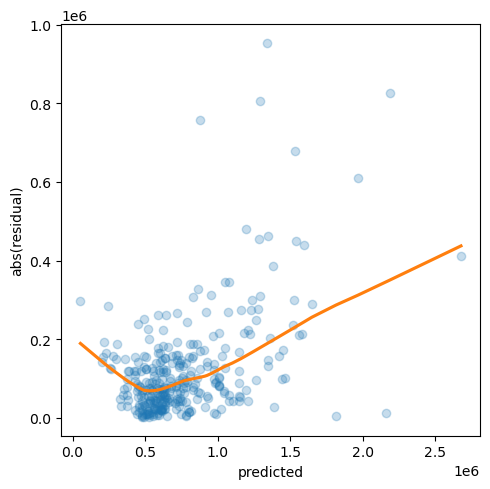

In [84]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=result_98105.fittedvalues, y=np.abs(result_98105.resid), 
            scatter_kws={'alpha': 0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

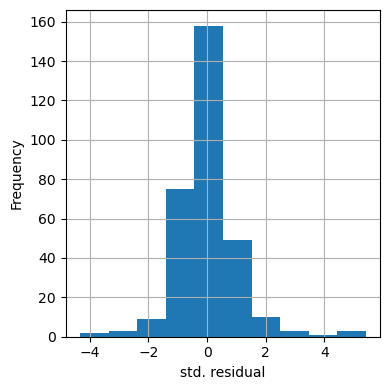

In [85]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

# Partial Residual Plots and Nonlinearity

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(result_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

# Polynomial and Spline Regression

In [86]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Sat, 22 Apr 2023   Prob (F-statistic):          9.95e-106
Time:                        21:08:53   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

The statsmodels implementation of a partial residual plot works only for linear term. Here is an implementation of a partial residual plot that, while inefficient, works for the polynomial regression.

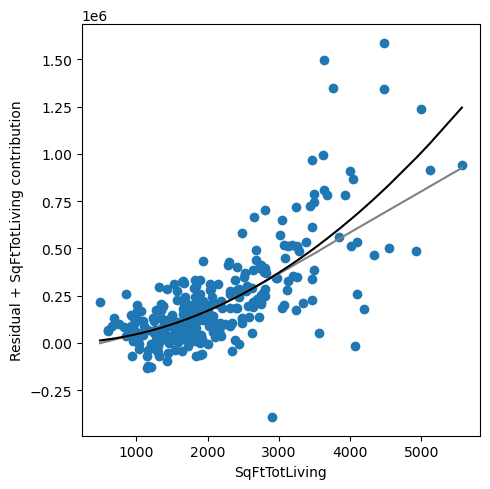

0.0387912816823115


In [87]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

## Splines

In [88]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Sat, 22 Apr 2023   Prob (F-statistic):          7.10e-104
Time:                        21:09:15   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


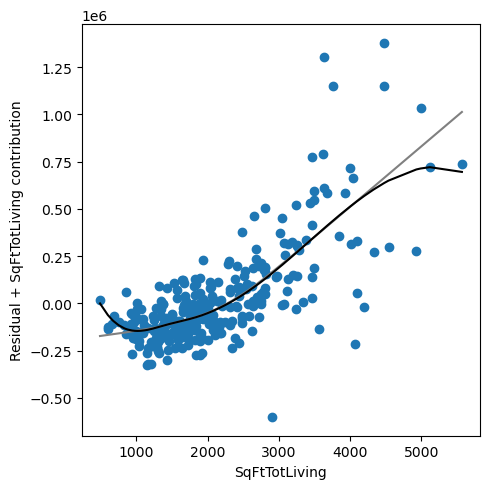

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()

# Generalized Additive Models

In [90]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1676
                                                Scale:                                    29480381715.8292
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

/var/folders/80/ghdt2w012_x2yg018vx45m300000gn/T/ipykernel_43856/661170992.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


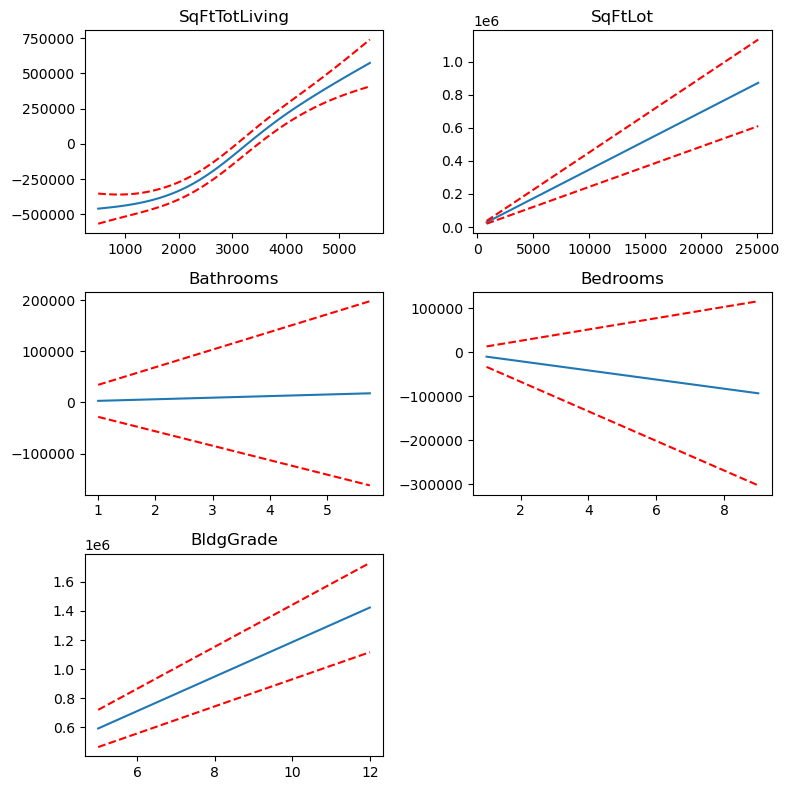

In [91]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

# Regularization
## Lasso

In [92]:
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

In [94]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv('/Users/amrapaliMac/Library/CloudStorage/OneDrive-Personal/Practical statistics for data scientists practice/house_sales.csv',
                    sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [95]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
columns = X.columns
# X = StandardScaler().fit_transform(X * 1.0)
y = house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

LinearRegression()


In [96]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

Lasso(alpha=10)


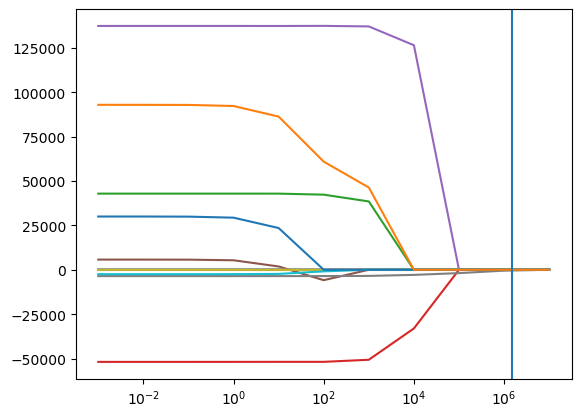

In [97]:
Method = LassoLars
MethodCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [98]:
pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})

,name,coef
0,SqFtTotLiving,289.048846
1,SqFtLot,0.029471
2,Bathrooms,0.000000
3,Bedrooms,-0.000000
4,BldgGrade,0.000000
5,NbrLivingUnits,-0.000000
6,SqFtFinBasement,3.316479
7,YrBuilt,-0.000000
8,YrRenovated,45.727472
9,NewConstruction,-0.000000


In [99]:
# Intercept: 6177658.144
# Coefficients:
#  SqFtTotLiving: 199.27474217544048
#  BldgGrade: 137181.13724627026
#  YrBuilt: -3564.934870415041
#  Bedrooms: -51974.76845567939
#  Bathrooms: 42403.059999677665
#  PropertyType_Townhouse: 84378.9333363999
#  SqFtFinBasement: 7.032178917565108
#  PropertyType_Single Family: 22854.87954019308